# 使用ReLU神经网络进行函数拟合

本notebook实现了一个使用两层ReLU神经网络来拟合自定义函数的功能。我们将拟合以下函数：

f(x) = sin(x) + 0.5*cos(2x) + 0.25*sin(3x)

## 1. 导入必要的库

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

## 2. 定义目标函数和数据生成

In [7]:
# 定义要拟合的函数
def target_function(x, func_type):
    if func_type == 1:
        return np.sin(x) + 0.5 * np.cos(2*x) + 0.25 * np.sin(3*x)  # 复杂三角函数
    elif func_type == 2:
        return np.exp(-x**2)  # 高斯函数
    elif func_type == 3:
        return np.tanh(x)  # 双曲正切函数
    else:
        return np.abs(x)  # 绝对值函数

# 生成数据
def generate_data(n_samples=1000, func_type=1, xlim=(-4*np.pi, 4*np.pi)):
    """
    生成训练和测试数据
    
    Args:
        n_samples: 样本数量
        func_type: 函数类型
        xlim: 数据分布范围
    """
    rng = np.random.default_rng(42)
    low, high = xlim
    x = rng.uniform(low, high, (n_samples, 1))
    y = target_function(x, func_type)
    return x, y

## 3. 定义神经网络相关函数

In [8]:
# ReLU激活函数
def relu(x):
    return np.maximum(0, x)

# 前向传播
def forward(x, w1, b1, w2, b2):
    # 第一层
    z1 = np.dot(x, w1) + b1
    a1 = relu(z1)
    
    # 输出层
    z2 = np.dot(a1, w2) + b2
    return z2, a1

# 反向传播
def backward(x, y, w1, b1, w2, b2, learning_rate):
    # 前向传播
    output, a1 = forward(x, w1, b1, w2, b2)
    
    # 计算损失
    loss = np.mean((output - y) ** 2)
    
    # 计算梯度
    m = x.shape[0]
    dz2 = output - y
    dw2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0, keepdims=True) / m
    
    da1 = np.dot(dz2, w2.T)
    dz1 = da1 * (a1 > 0)  # ReLU的导数
    dw1 = np.dot(x.T, dz1) / m
    db1 = np.sum(dz1, axis=0, keepdims=True) / m
    
    # 更新参数
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2
    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    
    return loss

## 4. 定义训练函数

In [9]:
def train(x, y, hidden_size=128, epochs=2000, learning_rate=0.005, patience=100):
    """
    训练模型
    
    Args:
        x: 输入数据
        y: 标签
        hidden_size: 隐藏层神经元数量
        epochs: 训练轮数
        learning_rate: 学习率
        patience: 早停耐心值
    """
    # 数据标准化
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y)
    
    # 初始化参数（使用He初始化）
    input_size = 1
    w1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / (input_size + hidden_size))
    b1 = np.zeros((1, hidden_size))
    w2 = np.random.randn(hidden_size, 1) * np.sqrt(2.0 / (hidden_size + 1))
    b2 = np.zeros((1, 1))
    
    # 训练循环
    losses = []
    best_loss = float('inf')
    no_improve = 0
    learning_rate_schedule = learning_rate * np.exp(-np.arange(epochs) / 1000)  # 学习率衰减
    
    for epoch in range(epochs):
        # 更新学习率
        current_lr = learning_rate_schedule[epoch]
        
        # 前向传播和反向传播
        loss = backward(x_scaled, y_scaled, w1, b1, w2, b2, current_lr)
        losses.append(loss)
        
        # 早停检查
        if loss < best_loss:
            best_loss = loss
            no_improve = 0
            best_w1 = w1.copy()
            best_b1 = b1.copy()
            best_w2 = w2.copy()
            best_b2 = b2.copy()
        else:
            no_improve += 1
            
        if no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
            
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss:.4f}, LR: {current_lr:.6f}')
    
    return best_w1, best_b1, best_w2, best_b2, losses, scaler_x, scaler_y


## 5. 生成数据并训练模型

Epoch 100, Loss: 0.9786, LR: 0.004529
Epoch 200, Loss: 0.9673, LR: 0.004098
Epoch 300, Loss: 0.9605, LR: 0.003708
Epoch 400, Loss: 0.9561, LR: 0.003355
Epoch 500, Loss: 0.9530, LR: 0.003036
Epoch 600, Loss: 0.9507, LR: 0.002747
Epoch 700, Loss: 0.9489, LR: 0.002485
Epoch 800, Loss: 0.9475, LR: 0.002249
Epoch 900, Loss: 0.9464, LR: 0.002035
Epoch 1000, Loss: 0.9455, LR: 0.001841
Epoch 1100, Loss: 0.9448, LR: 0.001666
Epoch 1200, Loss: 0.9441, LR: 0.001507
Epoch 1300, Loss: 0.9436, LR: 0.001364
Epoch 1400, Loss: 0.9431, LR: 0.001234
Epoch 1500, Loss: 0.9427, LR: 0.001117
Epoch 1600, Loss: 0.9424, LR: 0.001010
Epoch 1700, Loss: 0.9421, LR: 0.000914
Epoch 1800, Loss: 0.9418, LR: 0.000827
Epoch 1900, Loss: 0.9415, LR: 0.000749
Epoch 2000, Loss: 0.9413, LR: 0.000677
Epoch 100, Loss: 0.9634, LR: 0.004529
Epoch 200, Loss: 0.9192, LR: 0.004098
Epoch 300, Loss: 0.8901, LR: 0.003708
Epoch 400, Loss: 0.8685, LR: 0.003355
Epoch 500, Loss: 0.8518, LR: 0.003036
Epoch 600, Loss: 0.8385, LR: 0.002747
E

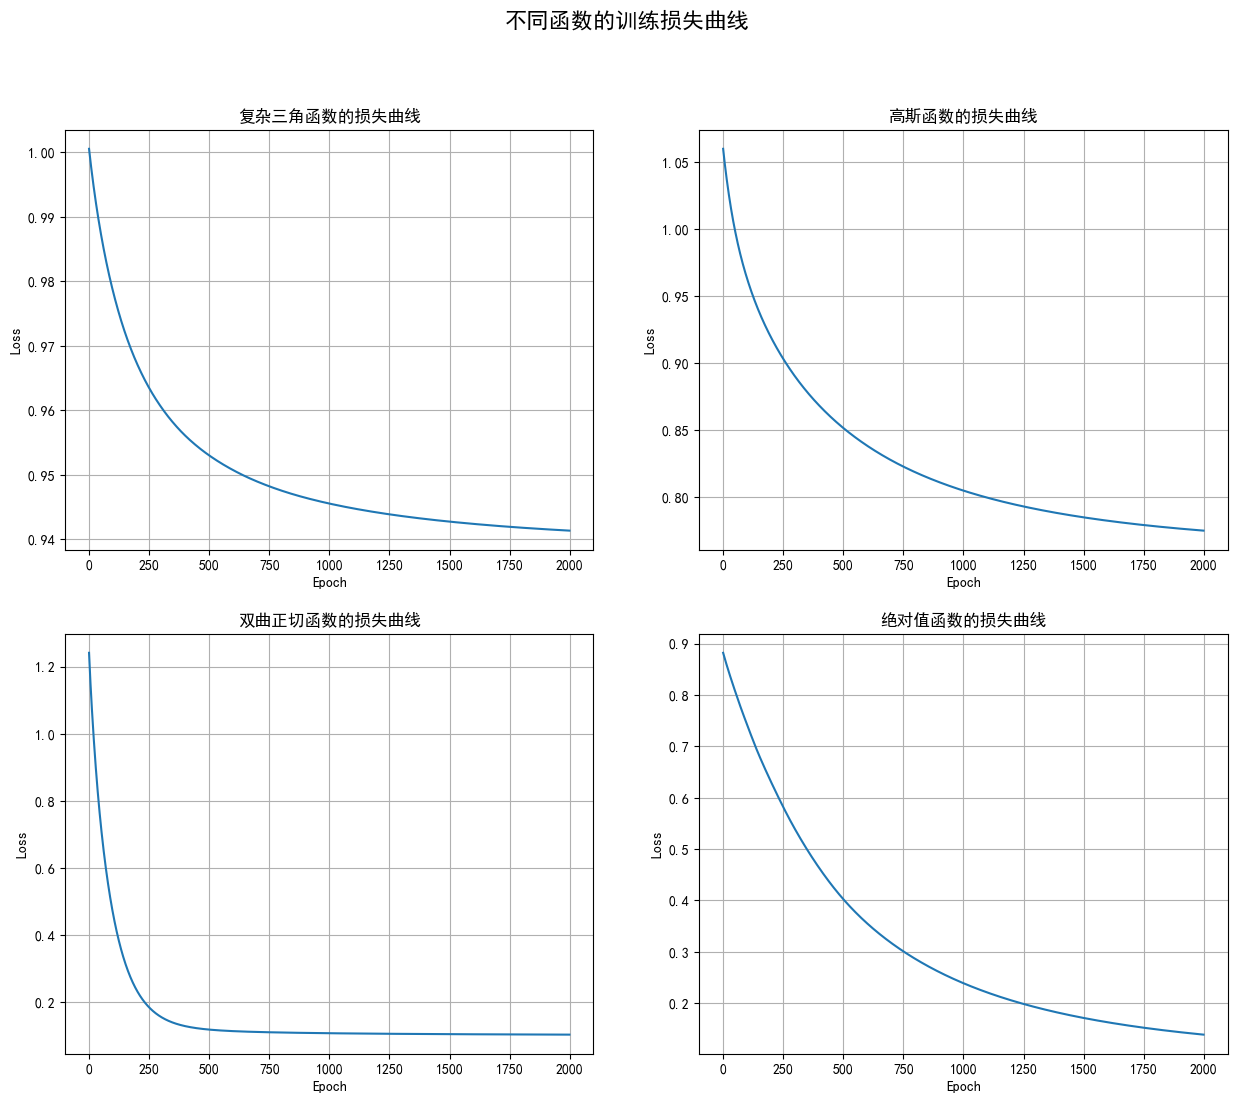

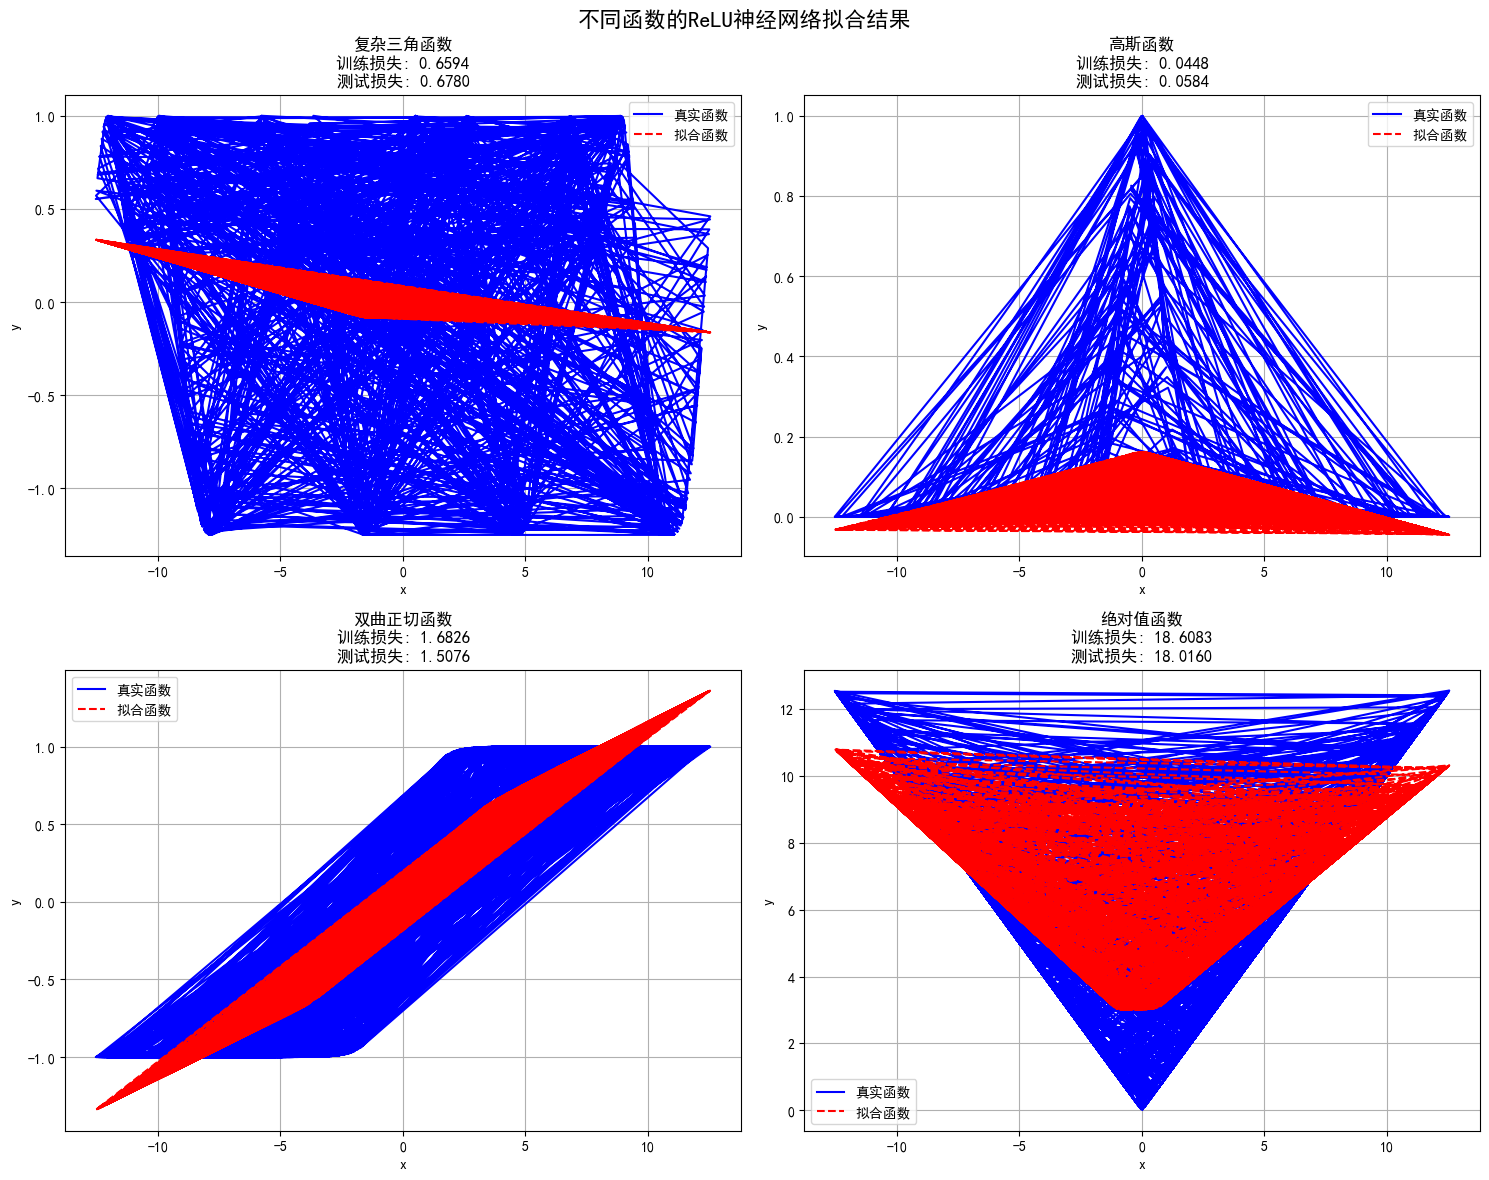

<Figure size 640x480 with 0 Axes>

In [10]:
# 创建2x2的子图用于显示拟合结果
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('不同函数的ReLU神经网络拟合结果', fontsize=16)

# 创建2x2的子图用于显示损失曲线
fig_loss, axes_loss = plt.subplots(2, 2, figsize=(15, 12))
fig_loss.suptitle('不同函数的训练损失曲线', fontsize=16)

# 函数名称列表
func_names = ['复杂三角函数', '高斯函数', '双曲正切函数', '绝对值函数']

# 创建DataFrame记录结果
results_df = pd.DataFrame(columns=['训练损失', '测试损失', '训练时间'])

# 对每个函数进行拟合
for i, func_type in enumerate([1, 2, 3, 4]):
    # 生成数据
    x, y = generate_data(n_samples=1000, func_type=func_type)
    
    # 划分训练集和测试集
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    # 记录开始时间
    start_time = time.time()
    
    # 训练模型
    w1, b1, w2, b2, losses, scaler_x, scaler_y = train(x_train, y_train)
    
    # 计算训练时间
    train_time = time.time() - start_time
    
    # 预测
    x_scaled = scaler_x.transform(x)
    y_pred_scaled, _ = forward(x_scaled, w1, b1, w2, b2)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    
    # 计算训练集和测试集损失
    train_loss = np.mean((y_pred[:len(y_train)] - y_train) ** 2)
    test_loss = np.mean((y_pred[len(y_train):] - y_test) ** 2)
    
    # 记录结果
    results_df.loc[func_names[i]] = [train_loss, test_loss, train_time]
    
    # 绘制拟合结果
    ax = axes[i//2, i%2]
    ax.plot(x, y, 'b-', label='真实函数')
    ax.plot(x, y_pred, 'r--', label='拟合函数')
    ax.set_title(f'{func_names[i]}\n训练损失: {train_loss:.4f}\n测试损失: {test_loss:.4f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.legend()
    
    # 绘制损失曲线
    ax_loss = axes_loss[i//2, i%2]
    ax_loss.plot(losses)
    ax_loss.set_title(f'{func_names[i]}的损失曲线')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.grid(True)

# 调整子图布局
plt.figure(fig.number)
plt.tight_layout()
plt.show()

plt.figure(fig_loss.number)
plt.tight_layout()
plt.show()


In [11]:
# 显示结果表格
print("\n模型评估结果：")
print(results_df)


模型评估结果：
             训练损失       测试损失      训练时间
复杂三角函数   0.659440   0.678047  0.862182
高斯函数     0.044814   0.058422  0.831822
双曲正切函数   1.682649   1.507579  0.956324
绝对值函数   18.608293  18.015971  0.841077


: 